<a href="https://colab.research.google.com/github/Jojocko/Feedback-users-supply-chain/blob/main/Rendu_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Datasets NLP/dataset_supplychain.csv')
df.head(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Commentaire,star,date,client,reponse,source,company,langage,cleaned_words,cleaned_lemma,Sentiment
0,"Colis commandé mardi 28 fevrier 23 , livraiso...",1,2023-03-07,Toto,NaN,TrustPilot,Amazon,fr,colis commandé mardi fevrier livraison jeu...,colis commander mardi fevrier livraison je...,__label__NEGATIVE
1,Amazon avec sa politique de retour est la pire...,1,2023-03-07,nasri eddine,NaN,TrustPilot,Amazon,fr,amazon politique pire contrairement ...,amazon politique pire contrairement ...,__label__NEGATIVE
2,Dieu sait que j'en connais des déboires avec l...,4,2023-03-07,Amandine,NaN,TrustPilot,Amazon,fr,dieu connais déboires sites marchands ...,dieu connaître déboire site marchand a...,__label__POSITIVE
3,"Nul, preleve une commande que je n'ai jamais r...",1,2023-03-07,Bob Brico,NaN,TrustPilot,Amazon,fr,preleve commande jamais reçu service cl...,prelev commande jamais recevoir service...,__label__NEGATIVE
4,Colis soit disant livré mais jamais reçu donc ...,1,2023-03-06,Client,NaN,TrustPilot,Amazon,fr,colis disant livré jamais reçu perdu non re...,colis dire livrer jamais recevoir perdre no...,__label__NEGATIVE


In [ ]:
# Traitement des colonnes pour une visualisation plus précise cohérente

df = df.drop(['client', 'langage', 'reponse'], axis=1)
df.rename(columns={'Sentiment': 'sentiment', 'Commentaire': 'commentaire'}, inplace=True)
df['sentiment'] = df['sentiment'].replace({'__label__POSITIVE': 'positif', '__label__NEGATIVE': 'negatif', '__label__NEUTRAL': 'neutre'})
df['date'] = df['date'].fillna(method="ffill")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

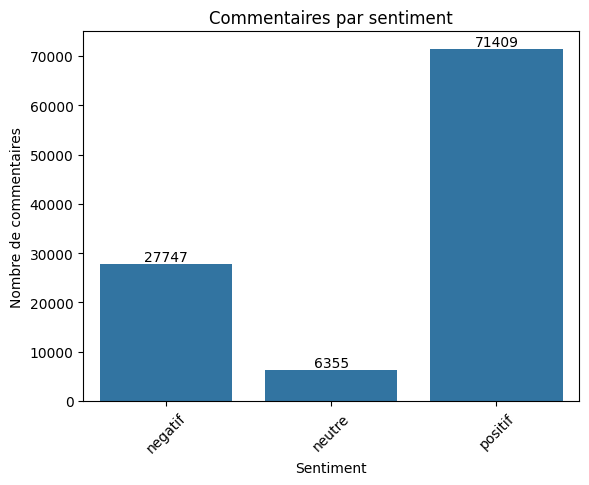

In [ ]:
# Nombre de commentaires par sentiment

import seaborn as sns
import matplotlib.pyplot as plt

sentiment = df.groupby('sentiment')['commentaire'].count()

sns.barplot(x=sentiment.index, y=sentiment.values)

plt.xlabel('Sentiment')
plt.ylabel('Nombre de commentaires')
plt.title('Commentaires par sentiment')
plt.xticks(rotation=45)
for index, value in enumerate(sentiment.values):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.show()

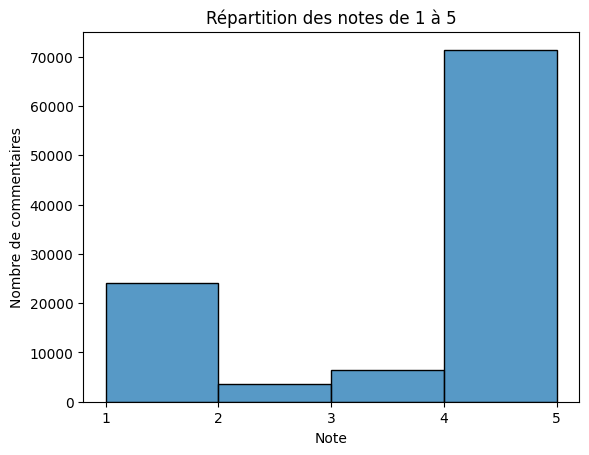

In [ ]:
# Répartition des notes

plt.figure
sns.histplot(data=df, x='star', binwidth=1, kde=False)

plt.xlabel('Note')
plt.ylabel('Nombre de commentaires')
plt.title('Répartition des notes de 1 à 5')
plt.xticks(range(1, 6))
plt.show()

Les données indiquent une prédominance de commentaires positifs et de notations à cinq étoiles. Les notes de deux et trois étoiles sont peu fréquentes, ce qui suggère que les utilisateurs ont tendance à laisser des commentaires lorsqu'ils sont soit très satisfaits, ou bien soit très insatisfaits. Il serait bénéfique d'examiner le contenu des commentaires négatifs afin d'identifier les aspects à améliorer.

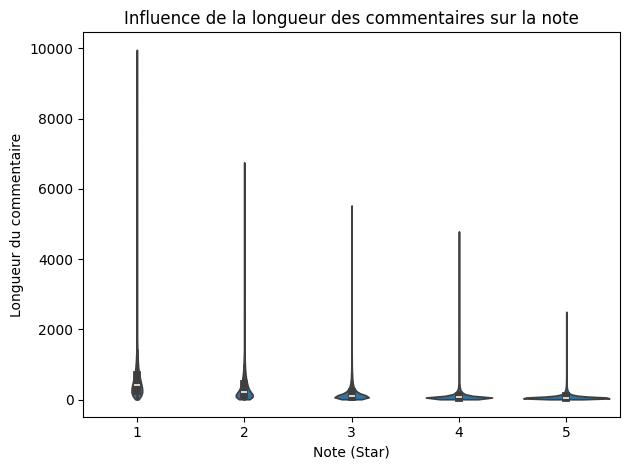

In [ ]:
# Influence de l'impact de la longueur d'un commentaire sur la note

df['length'] = df['commentaire'].str.len()

fig, ax = plt.subplots()
sns.violinplot(x="star", y="length", data=df, ax=ax, cut=0)
ax.set_title('Influence de la longueur des commentaires sur la note')
ax.set_xlabel('Note (Star)')
ax.set_ylabel('Longueur du commentaire')
plt.tight_layout()
plt.show()


Les commentaires associés à des notes positives (4 ou 5 étoiles) sont généralement plus brefs. À mesure que les évaluations deviennent plus négatives, les commentaires ont tendance à être plus détaillés, ce qui suggère des critiques constructives de la part de clients mécontents. Cela souligne l'importance d'analyser ces retours pour comprendre les points de mécontentement.

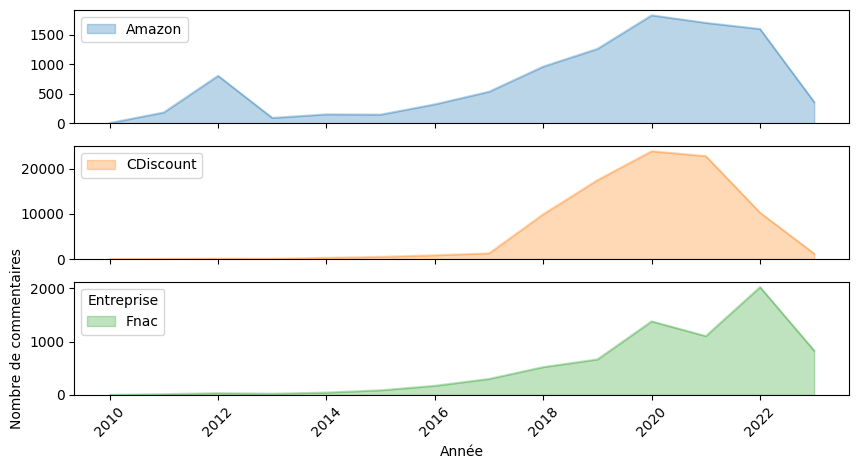

In [ ]:
# Évolution du nombre de commentaires

pivot_table = df.pivot_table(values='commentaire',
                             index='year',
                             columns='company',
                             aggfunc='count')

pivot_table.plot(kind='area',
                 stacked=True,
                 alpha=0.3,
                 figsize=(10, 5),
                 subplots=True)
plt.xlabel('Année')
plt.xticks(rotation=45)
plt.ylabel('Nombre de commentaires')
plt.legend(title='Entreprise')
plt.show()

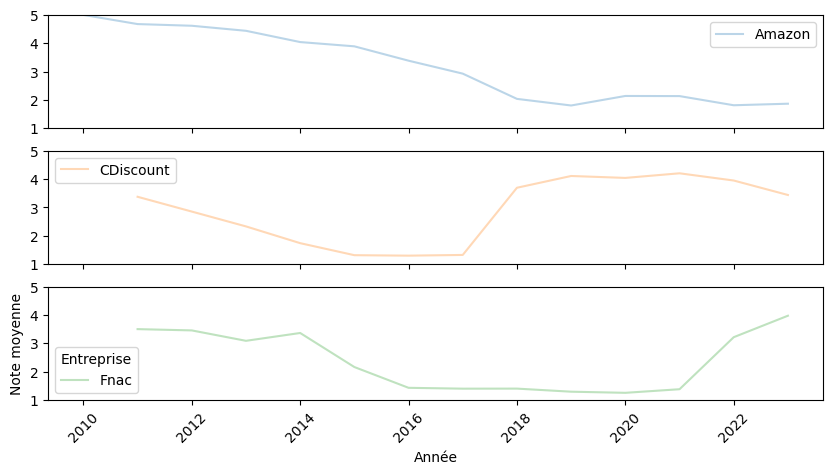

In [ ]:
# Évolution des notes

pivot_table3 = df.pivot_table(values='star',
                             index='year',
                             columns='company',
                             aggfunc='mean')
pivot_table3.plot(kind='line',
                 stacked=False,
                 alpha=0.3,
                 figsize=(10, 5),
                 subplots=True,
                 yticks=[1, 2, 3, 4, 5],
                 ylim=(1, 5)
                )
plt.ylabel('Note moyenne')
plt.xlabel('Année')
plt.xticks(rotation=45)
plt.legend(title='Entreprise')
plt.show()

Il est intéressant de noter que pour Fnac et CDiscount, lorsque le volume de commentaires à augmenté brutalement, les notes se sont améliorés drastiquement. Pour Amazon, l'augmentation du volume est continue tout comme la dégradation de la note. Probablement Fnac et CDiscount font en sorte de demander des commentaires positifs à leur clients sur Trustpilot.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


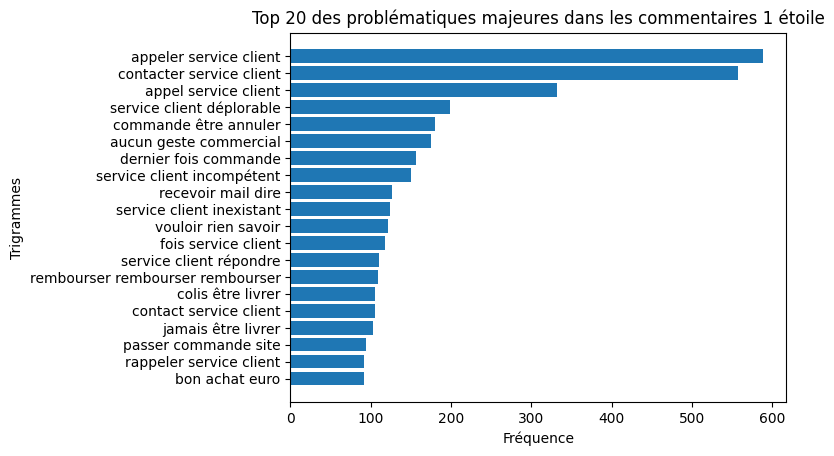

In [ ]:
# N-gramme pour observer les problématiques majeures

from nltk import bigrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import nltk

# Prétraitement des données

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('french'))

company = {'Fnac', 'fnac', 'Amazon', 'amazon', 'CDiscount', 'cdiscount'}

stop_words.update(company)

from nltk import trigrams

# Filtrage des commentaires à une étoile

df_1_stars = df[df['star'] == 1]
text_1_stars = ' '.join(df_1_stars['cleaned_lemma'].dropna())

words = [word for word in word_tokenize(text_1_stars.lower()) if word.isalpha() and word not in stop_words]

# Trigramme

trigrammes = list(trigrams(words))
trigramme_freq = Counter(trigrammes)
top_20_trigrammes = trigramme_freq.most_common(20)
trigrammes_labels = [' '.join(trigram) for trigram, freq in top_20_trigrammes]
frequences = [freq for trigram, freq in top_20_trigrammes]

plt.figure
plt.barh(trigrammes_labels, frequences)
plt.xlabel('Fréquence')
plt.ylabel('Trigrammes')
plt.title('Top 20 des problématiques majeures dans les commentaires 1 étoile')
plt.gca().invert_yaxis()
plt.show()

Il apparaît que les problèmes de service client sont majeurs, suivis des problèmes de commande, de livraison et de remboursement.
Dans les prochains notebooks, nous allons tenter de labeliser les commentaires négatifs selon la problématique majeure identifiée dans chaque commentaire. Il s'agira donc d'un problème de classification.